# MNIST CNN - Simple Implementation

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [10]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
model = MNISTCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Using device: {device}")

Total parameters: 3,309,578
Using device: cpu


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_accs = [], []
best_acc = 0
patience_counter = 0

for epoch in range(20):
    model.train()
    train_loss = 0
    
    for data, target in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    train_loss /= len(train_loader)
    val_acc = 100 * correct / total
    
    train_losses.append(train_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}: Loss: {train_loss:.4f}, Accuracy: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print(f'Early stopping at epoch {epoch+1}')
            break

print(f'Best accuracy: {best_acc:.2f}%')

Epoch 1: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]



Epoch 1: Loss: 0.1459, Accuracy: 98.50%


Epoch 2: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]



Epoch 2: Loss: 0.0467, Accuracy: 99.08%


Epoch 3: 100%|██████████| 469/469 [00:42<00:00, 11.14it/s]



Epoch 3: Loss: 0.0334, Accuracy: 98.80%


Epoch 4: 100%|██████████| 469/469 [01:35<00:00,  4.90it/s]



Epoch 4: Loss: 0.0274, Accuracy: 99.20%


Epoch 5: 100%|██████████| 469/469 [01:03<00:00,  7.41it/s]



Epoch 5: Loss: 0.0211, Accuracy: 99.28%


Epoch 6: 100%|██████████| 469/469 [00:53<00:00,  8.84it/s]


Epoch 6: Loss: 0.0176, Accuracy: 99.38%


Epoch 7: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]



Epoch 7: Loss: 0.0143, Accuracy: 99.20%


Epoch 8: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]


Epoch 8: Loss: 0.0128, Accuracy: 99.37%


Epoch 9: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]



Epoch 9: Loss: 0.0117, Accuracy: 99.19%


Epoch 10: 100%|██████████| 469/469 [01:04<00:00,  7.30it/s]



Epoch 10: Loss: 0.0103, Accuracy: 99.39%


Epoch 11: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 11: Loss: 0.0093, Accuracy: 99.38%


Epoch 12: 100%|██████████| 469/469 [00:55<00:00,  8.45it/s]



Epoch 12: Loss: 0.0094, Accuracy: 99.32%


Epoch 13: 100%|██████████| 469/469 [01:01<00:00,  7.64it/s]



Epoch 13: Loss: 0.0095, Accuracy: 99.31%


Epoch 14: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]



Epoch 14: Loss: 0.0073, Accuracy: 99.31%


Epoch 15: 100%|██████████| 469/469 [01:10<00:00,  6.65it/s]



Epoch 15: Loss: 0.0068, Accuracy: 99.36%
Early stopping at epoch 15
Best accuracy: 99.39%


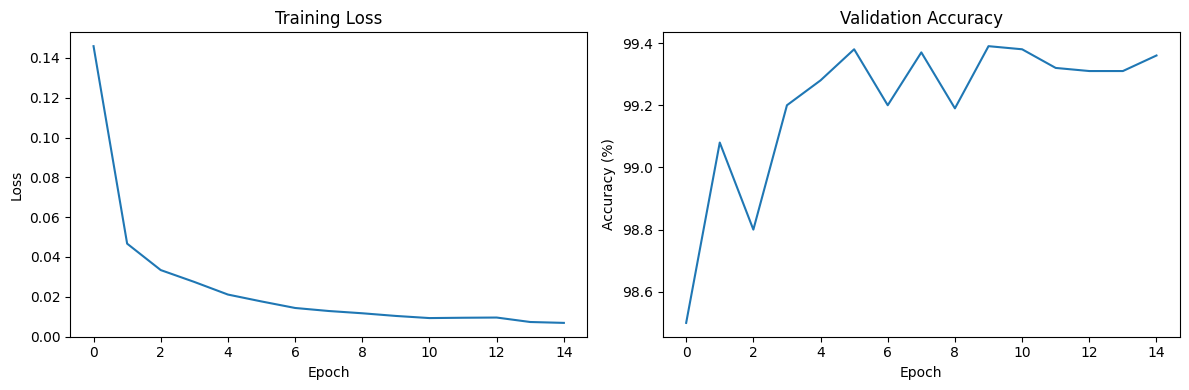

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

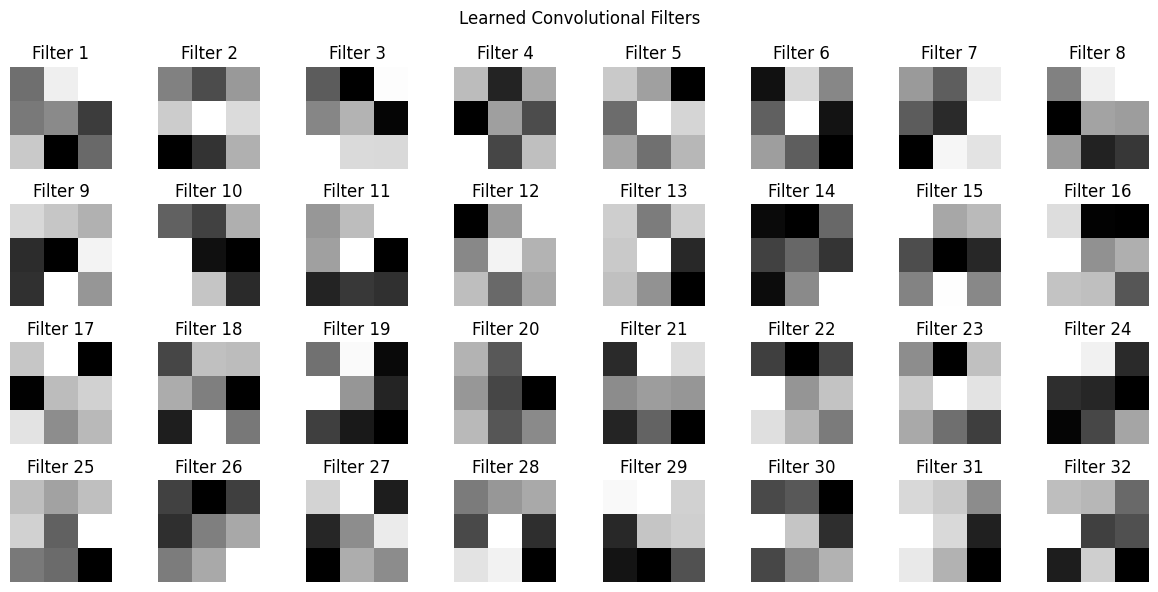

In [15]:
weights = model.conv1.weight.data.cpu()
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:
        ax.imshow(weights[i, 0], cmap='gray')
        ax.set_title(f'Filter {i+1}')
    ax.axis('off')
plt.suptitle('Learned Convolutional Filters')
plt.tight_layout()
plt.show()

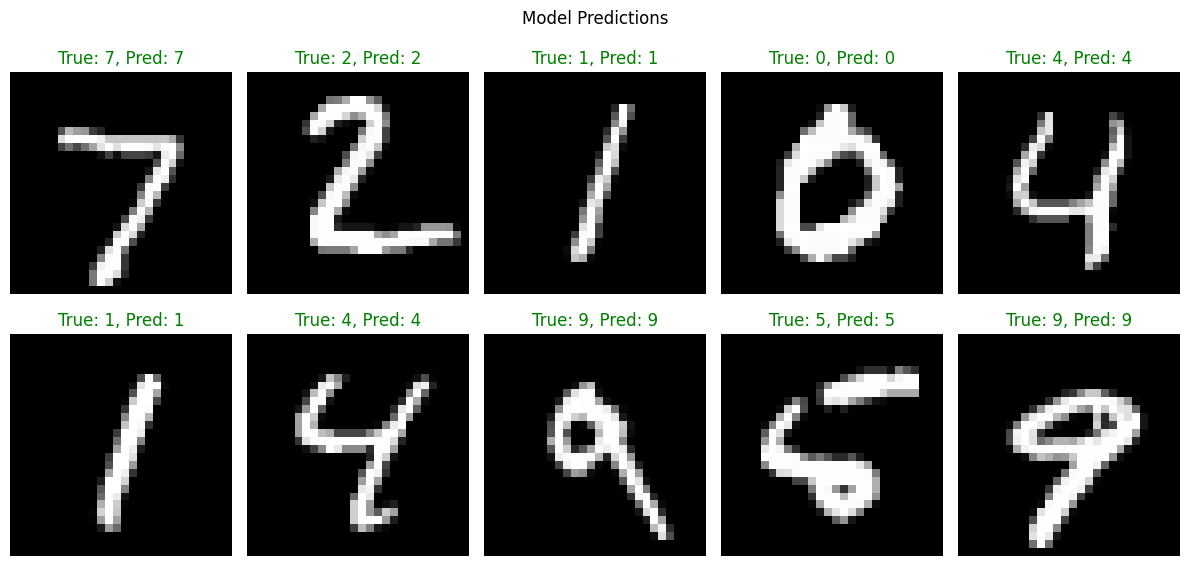

In [16]:
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze()
    ax.imshow(img, cmap='gray')
    color = 'green' if labels[i] == predicted[i] else 'red'
    ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}', color=color)
    ax.axis('off')
plt.suptitle('Model Predictions')
plt.tight_layout()
plt.show()